## Scraping Walmart by Scraping Fish 🐟

This notebook is using Walmar product details data scraped from Walmart using [Scraping Fish API](https://scrapingfish.com). To be able to scrape the data and run it, you will need Scraping Fish API key which you can get for just $2 here: [Scraping Fish Request Packs](https://scrapingfish.com/buy). Without Scraping Fish API key you are likely to see captcha instead of useful product information ⛔️.

## Imports

In [1]:
import json
import pathlib
import pandas as pd

## Parse data and load it into pandas data frame

In [2]:
def parse_amount(amount_str):
    amount = None
    try:
        if amount_str == "none":
            return amount
        if amount_str[:5] == "<lt/>":
            amount_str = amount_str[5:]
        elif amount_str[0] == "<":
            amount_str = amount_str[1:]
        elif amount_str[:8] == "lessthan":
            amount_str = amount_str[8:]
        elif amount_str[:13] == "approximately":
            amount_str = amount_str[13:]
        if amount_str[-2:] == "mg":
            amount = float(amount_str[:-2]) * 0.001
        elif amount_str[-2:] == "oz":
            amount = float(amount_str[:-2]) * 28.35
        elif amount_str[-4:] == "floz":
            amount = float(amount_str[:-4]) * 29.57
        elif amount_str[-5:] == "grams":
            amount = float(amount_str[:-5])
        elif amount_str[-3:] == "grm":
            amount = float(amount_str[:-3])
        elif amount_str[-2:] == "gr":
            amount = float(amount_str[:-2])
        elif amount_str[-1] == "g":
            amount = float(amount_str[:-1])
        else:
            amount = float(amount_str)
    except ValueError as e:
        return None
    return amount

def product_dict(full_product_json):
    product_info = full_product_json.get("data", {}).get("product", {}) or {}
    product = {
        "id": product_info.get("usItemId"),
        "name": product_info.get("name"),
        "rating": product_info.get("averageRating"),
        "price": (product_info.get("priceInfo", {}).get("currentPrice", {}) or {}).get("price"),
    }
    for i, c in enumerate(product_info.get("category", {}).get("path", [])):
        product[f"category_{i}"] = c.get("name")
    product_nutrients = (full_product_json.get("data", {}).get("idml", {}) or {}).get("nutritionFacts", {}) or {}
    calories_str = (product_nutrients.get("calorieInfo", {}) or {}).get("mainNutrient", {}).get("amount")
    for nutrient in (product_nutrients.get("keyNutrients", {}) or {}).get("values", []):
        main_nutrient = nutrient.get("mainNutrient", {})        
        product[main_nutrient.get("name")] = parse_amount(str(main_nutrient.get("amount")).lower())
        for child_nutrient in (main_nutrient.get("childNutrients", []) or []):
            product[child_nutrient.get("name")] = parse_amount(str(child_nutrient.get("amount")).lower())
        for child_nutrient in (nutrient.get("childNutrients", []) or []):
            product[child_nutrient.get("name")] = parse_amount(str(child_nutrient.get("amount")).lower())
    return product

products = []
for json_file_path in pathlib.Path("./products/").glob("*.json"):
    with open(json_file_path, "r") as f:
        product_json = json.load(f)
        products.append(product_dict(product_json))

df = pd.DataFrame(products)
df

,id,name,rating,price,category_0,category_1,category_2,category_3,Total Fat,Saturated Fat,...,category_4,Includes Added Sugars,Soluble Fiber,Insoluble Fiber,Polyunsaturated Fat,Monounsaturated Fat,category_5,Sugar Alcohol,Other Carbohydrate,category_6
0,839902973,Ford Edge 2012-13 Ginger Ale Metallic M7262A B...,NaN,43.66,Auto & Tires,Auto Detailing Paint and Paint Tools,"Automotive Paint, Paint Tools & Accessories",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,585673013,"Harney & Sons, Chocolate, Black Tea with Choco...",NaN,16.96,Food,Beverages,Tea,Black Tea,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,54049493,Birds Eye Steamfresh Red Potatoes & Green Bean...,NaN,2.36,Food,Frozen Foods,Frozen Fruits & Vegetables,Frozen Vegetables,1.5,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,950055046,"Kitu Super Coffee, Caramel Espresso Coffee, 4 ...",4.2,8.48,Food,Coffee,Bottled Coffee,Kitu Super Coffee,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,599512304,"2 PACK | Whole Fancy Cashews, 2.5 lbs 2 Pack",NaN,49.54,Food,"Snacks, Cookies & Chips","Nuts, Trail Mix & Seeds","All Nuts, Trail Mix,& Seeds",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71067,311783924,"KIT KAT®, DUOS Strawberry Flavored Creme and D...",5.0,1.14,Food,Candy,Chocolate,Chocolate Bars,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71068,193599072,"Organic Pine Nuts, 0.5 Pounds — Non-GMO, Koshe...",5.0,16.99,Food,"Snacks, Cookies & Chips","Nuts, Trail Mix & Seeds",Pine Nuts,19.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71069,1894077295,Pringles Ranch Flavored Potato Crisps (2) 5.96...,NaN,29.96,Food,"Snacks, Cookies & Chips",Chips,Pringles Convenient Pack,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71070,10535570,Community Coffee Signature Iced Tea 24 Ct Box,4.8,12.95,Food,Beverages,Tea,All Tea,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data cleaning

In [3]:
# remove columns and rows with missing values
df = df.dropna(subset=["id", "category_0"], how="any")
df = df.dropna(subset=[
    'Total Fat',
    'Saturated Fat',
    'Trans Fat',
    'Total Carbohydrate',
    'Dietary Fiber',
    'Sugars',
    'Protein',
    'Includes Added Sugars',
    'Soluble Fiber',
    'Insoluble Fiber',
    'Polyunsaturated Fat',
    'Monounsaturated Fat',
    'Sugar Alcohol',
    'Other Carbohydrate'
], how="all")
df = df.dropna(axis="columns", how="all")
df

,id,name,rating,price,category_0,category_1,category_2,category_3,Total Fat,Saturated Fat,...,Protein,category_4,Includes Added Sugars,Soluble Fiber,Insoluble Fiber,Polyunsaturated Fat,Monounsaturated Fat,category_5,Sugar Alcohol,Other Carbohydrate
2,54049493,Birds Eye Steamfresh Red Potatoes & Green Bean...,NaN,2.36,Food,Frozen Foods,Frozen Fruits & Vegetables,Frozen Vegetables,1.5,1.0,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,950055046,"Kitu Super Coffee, Caramel Espresso Coffee, 4 ...",4.2,8.48,Food,Coffee,Bottled Coffee,Kitu Super Coffee,1.0,1.0,...,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,838198595,"Califia Farms Almondmilk Coffee Creamer, Baris...",NaN,30.59,Food,Dairy & Eggs,Milk,Plant Based Milk,4.5,0.0,...,2.0,Califia Milk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,52681183,"Cattleman's Cut Teriyaki Beef Jerky, High Prot...",4.0,21.99,Food,"Snacks, Cookies & Chips",Beef Jerky and Dried Meats,Keto Friendly Jerky,0.5,0.0,...,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,21118545,"Ting Soda, 67.6 Fl Oz, 1 Ct",5.0,2.80,Food,Beverages,Soda Pop,All Soda Pop,0.0,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71055,968576413,Kutztown Soda- Your Choice of 9 Flavors in a C...,NaN,66.95,Food,Beverages,Soda Pop,All Soda Pop,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71056,10307508,"Blue Diamond Whole Natural Almonds, 6 oz",4.7,10.88,Food,"Snacks, Cookies & Chips","Nuts, Trail Mix & Seeds",Almonds,14.0,1.0,...,6.0,Blue Diamond Almonds,NaN,NaN,NaN,3.5,9.0,NaN,NaN,NaN
71057,26968699,"Nutiva Organic Manna - Coconut , 15 Oz",4.5,15.47,Premium Beauty,BeautySpaceNK,Beauty by brand,Juice Beauty,9.0,8.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71068,193599072,"Organic Pine Nuts, 0.5 Pounds — Non-GMO, Koshe...",5.0,16.99,Food,"Snacks, Cookies & Chips","Nuts, Trail Mix & Seeds",Pine Nuts,19.0,1.0,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# drop columns not required in our use case
df = df.drop(columns=["category_2", "category_3", "category_4", "category_5", "Sodium"])

# fill missing values with 0s
df[["Total Fat", "Saturated Fat", "Trans Fat", "Polyunsaturated Fat", "Monounsaturated Fat"]] = df[
    ["Total Fat", "Saturated Fat", "Trans Fat", "Polyunsaturated Fat", "Monounsaturated Fat"]
].fillna(0)
df[["Cholesterol", "Protein"]] = df[["Cholesterol", "Protein"]].fillna(0)
df[["Total Carbohydrate", "Other Carbohydrate", "Dietary Fiber", "Soluble Fiber", "Insoluble Fiber"]] = df[
    ["Total Carbohydrate", "Other Carbohydrate", "Dietary Fiber", "Soluble Fiber", "Insoluble Fiber"]
].fillna(0)
df[["Sugars", "Includes Added Sugars", "Sugar Alcohol"]] = df[
    ["Sugars", "Includes Added Sugars", "Sugar Alcohol"]
].fillna(0)
df["rating"] = df["rating"].fillna(0)

# combine fat into one nutrient
df["Fat"] = df["Saturated Fat"] + df["Trans Fat"] + df["Polyunsaturated Fat"] + df["Monounsaturated Fat"]
df["Fat"] = df[["Total Fat", "Fat"]].max(axis=1)
df = df.drop(columns=["Total Fat", "Saturated Fat", "Trans Fat", "Polyunsaturated Fat", "Monounsaturated Fat"])

# combine carbohydrates into sugars and other carbohydrates
df["Fiber"] = df["Dietary Fiber"] + df["Soluble Fiber"] + df["Insoluble Fiber"]
df = df.drop(columns=["Dietary Fiber", "Soluble Fiber", "Insoluble Fiber"])
df["Sugars"] = df[["Sugars", "Includes Added Sugars"]].max(axis=1) + df["Sugar Alcohol"]
df = df.drop(columns=["Sugar Alcohol", "Includes Added Sugars"])
df["Other Carbohydrate"] = df["Other Carbohydrate"] + df["Fiber"]

# exclude products not in food category
df = df.loc[df["category_0"] == "Food"]
# exclude categories having less than 10 products
keep_categories = df.groupby("category_1")["id"].count().sort_values(ascending=False).to_frame().query("id > 10")
df = df.loc[df["category_1"].isin(keep_categories.index)]
# exclude outliers
df = df.loc[~((df["Protein"] > 1000) | (df["Sugars"] > 1000) | (df["Fat"] > 1000))]
# exlcude products with all considered nutrients having set to 0
df = df.loc[df[["Cholesterol", "Fat", "Protein", "Sugars", "Other Carbohydrate"]].max(axis=1) > 0]

# compute main nutrient
df["Main Nutrient"] = df[["Cholesterol", "Fat", "Protein", "Sugars", "Other Carbohydrate"]].idxmax(axis=1)
df

,id,name,rating,price,category_0,category_1,Cholesterol,Total Carbohydrate,Sugars,Protein,Other Carbohydrate,Fat,Fiber,Main Nutrient
2,54049493,Birds Eye Steamfresh Red Potatoes & Green Bean...,0.0,2.36,Food,Frozen Foods,5.000,15.0,3.0,3.0,6.0,1.5,6.0,Other Carbohydrate
3,950055046,"Kitu Super Coffee, Caramel Espresso Coffee, 4 ...",4.2,8.48,Food,Coffee,0.005,1.0,0.0,5.0,0.0,1.0,0.0,Protein
6,838198595,"Califia Farms Almondmilk Coffee Creamer, Baris...",0.0,30.59,Food,Dairy & Eggs,0.000,7.0,5.0,2.0,1.0,4.5,1.0,Sugars
8,52681183,"Cattleman's Cut Teriyaki Beef Jerky, High Prot...",4.0,21.99,Food,"Snacks, Cookies & Chips",0.030,9.0,7.0,10.0,0.0,0.5,0.0,Protein
10,21118545,"Ting Soda, 67.6 Fl Oz, 1 Ct",5.0,2.80,Food,Beverages,0.000,30.0,30.0,0.0,0.0,0.0,0.0,Sugars
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71050,906492216,Old Fashioned Chocolate Malt Hot Cocoa,5.0,13.75,Food,Beverages,0.005,30.0,26.0,2.0,1.0,2.5,1.0,Sugars
71054,100337691,(8 Pack)KindBar Chocolate Peanut Butter Filled...,0.0,53.52,Food,"Snacks, Cookies & Chips",0.000,20.0,0.0,4.0,0.0,9.0,0.0,Fat
71055,968576413,Kutztown Soda- Your Choice of 9 Flavors in a C...,0.0,66.95,Food,Beverages,0.000,31.0,31.0,0.0,0.0,0.0,0.0,Sugars
71056,10307508,"Blue Diamond Whole Natural Almonds, 6 oz",4.7,10.88,Food,"Snacks, Cookies & Chips",0.000,6.0,1.0,6.0,3.0,14.0,3.0,Fat


## Data exploration

### Product distribution by category

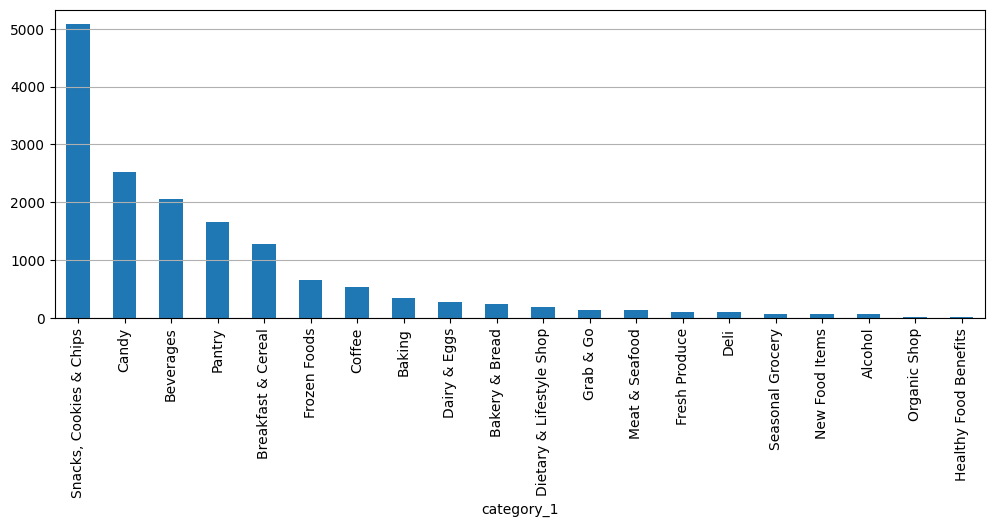

In [5]:
df.groupby("category_1")["id"].count().sort_values(ascending=False).plot.bar(figsize=(12, 4)).grid(axis='y')

### Distribution of main nutrient

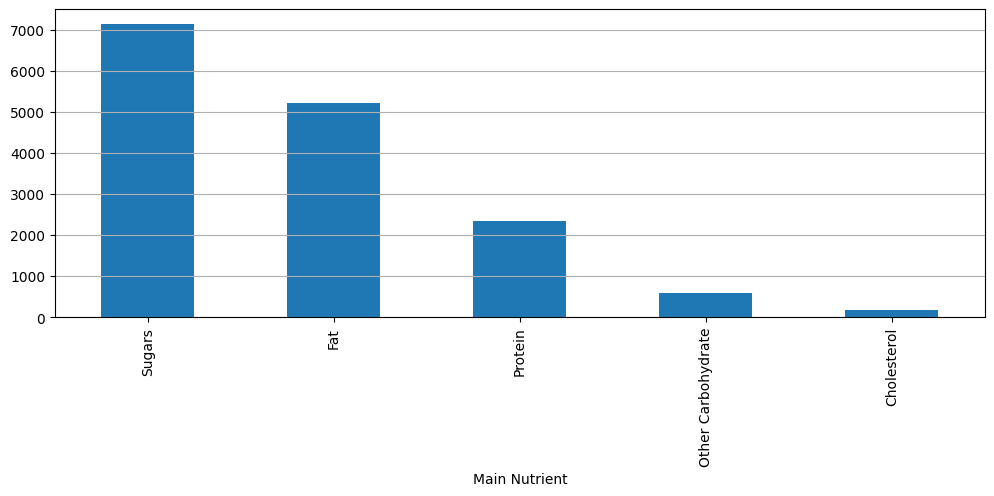

In [6]:
df.groupby("Main Nutrient")["id"].count().sort_values(ascending=False).plot.bar(figsize=(12, 4)).grid(axis='y')

<AxesSubplot: ylabel='id'>

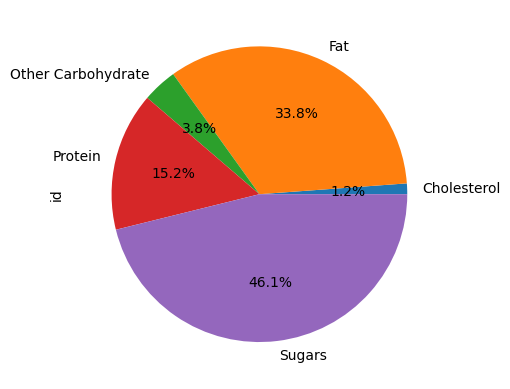

In [7]:
df.groupby("Main Nutrient")["id"].count().plot.pie(autopct="%1.1f%%")

<AxesSubplot: ylabel='id'>

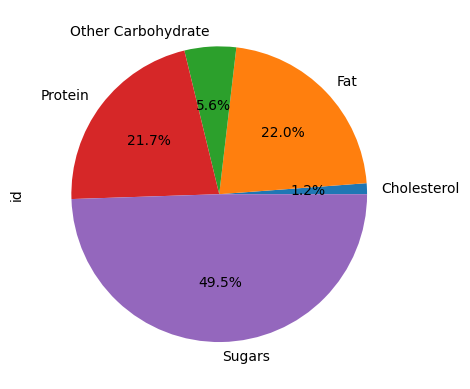

In [8]:
## excluding "Snacks, Cookies & Chips" and "Candy" categories
df.loc[
    ~df["category_1"].isin({"Snacks, Cookies & Chips", "Candy"})
].groupby("Main Nutrient")["id"].count().plot.pie(autopct="%1.1f%%")

### Product rating vs nutrients

In [9]:
df_with_rating = df.loc[df["rating"] > 0]
df_with_rating

,id,name,rating,price,category_0,category_1,Cholesterol,Total Carbohydrate,Sugars,Protein,Other Carbohydrate,Fat,Fiber,Main Nutrient
3,950055046,"Kitu Super Coffee, Caramel Espresso Coffee, 4 ...",4.2,8.48,Food,Coffee,0.005,1.0,0.0,5.0,0.0,1.0,0.0,Protein
8,52681183,"Cattleman's Cut Teriyaki Beef Jerky, High Prot...",4.0,21.99,Food,"Snacks, Cookies & Chips",0.030,9.0,7.0,10.0,0.0,0.5,0.0,Protein
10,21118545,"Ting Soda, 67.6 Fl Oz, 1 Ct",5.0,2.80,Food,Beverages,0.000,30.0,30.0,0.0,0.0,0.0,0.0,Sugars
27,10534933,"Smucker's Pecans in Syrup Topping, 5 Ounces",4.5,3.17,Food,Dietary & Lifestyle Shop,0.000,18.0,14.0,1.0,1.0,9.0,1.0,Sugars
31,22217916,"Heinz Tomato Ketchup, 38 oz Bottle",4.8,3.98,Food,Pantry,0.000,5.0,4.0,0.0,0.0,0.0,0.0,Sugars
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71038,21961722,Light + Fit Nonfat Gluten-Free Strawberry Gree...,4.5,3.88,Food,Dairy & Eggs,0.010,8.0,6.0,12.0,0.0,0.0,0.0,Protein
71041,170621163,Food To Live Antioxidant Mix of Sprouting See...,5.0,10.49,Food,Dietary & Lifestyle Shop,0.000,1.0,0.0,1.0,1.0,0.2,1.0,Protein
71050,906492216,Old Fashioned Chocolate Malt Hot Cocoa,5.0,13.75,Food,Beverages,0.005,30.0,26.0,2.0,1.0,2.5,1.0,Sugars
71056,10307508,"Blue Diamond Whole Natural Almonds, 6 oz",4.7,10.88,Food,"Snacks, Cookies & Chips",0.000,6.0,1.0,6.0,3.0,14.0,3.0,Fat


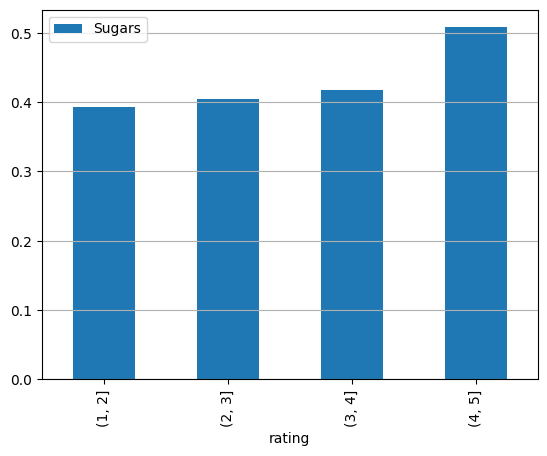

In [10]:
df_rating_sugar = pd.cut(df_with_rating["rating"], [1, 2, 3, 4, 5]).to_frame()
df_rating_sugar["Sugars"] = df_with_rating["Main Nutrient"] == "Sugars"
df_rating_sugar.groupby("rating").mean().plot(kind="bar").grid(axis='y')

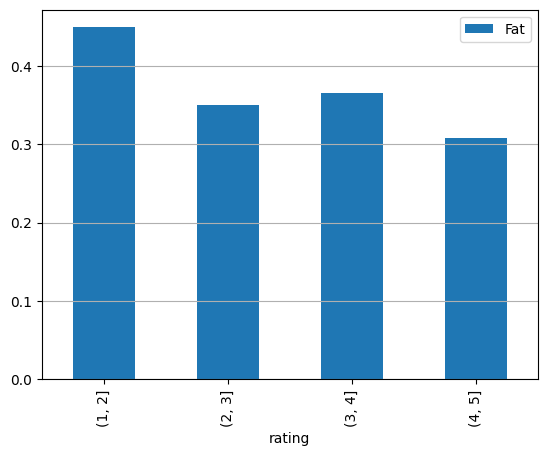

In [11]:
df_rating_fat = pd.cut(df_with_rating["rating"], [1, 2, 3, 4, 5]).to_frame()
df_rating_fat["Fat"] = df_with_rating["Main Nutrient"] == "Fat"
df_rating_fat.groupby("rating").mean().plot(kind="bar").grid(axis='y')

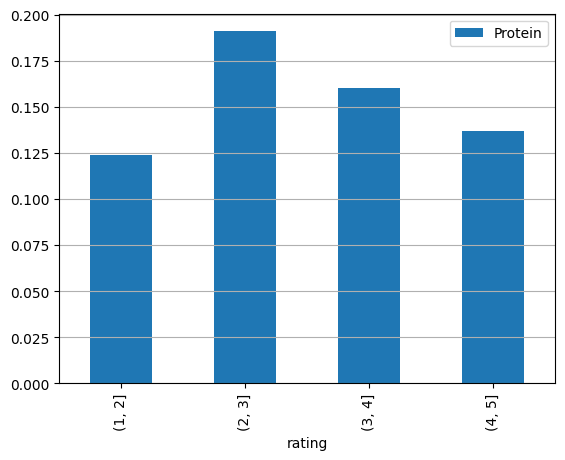

In [12]:
df_rating_protein = pd.cut(df_with_rating["rating"], [1, 2, 3, 4, 5]).to_frame()
df_rating_protein["Protein"] = df_with_rating["Main Nutrient"] == "Protein"
df_rating_protein.groupby("rating").mean().plot(kind="bar").grid(axis='y')